Purpose of this notebook is to use LORA (aka Low Rank Adaptation method) and finetune

In [1]:
# !python -m pip install -q datasets peft evaluate

In [2]:
# !python -m pip uninstall -y pyarrow datasets ibis-framework

In [3]:
# !python -m pip install pyarrow>=15.0.0 datasets peft evaluate

In [4]:
# !python -m pip show pyarrow datasets

In [5]:
# !python -m pip install pyarrow>=15.0.0 datasets peft evaluate

In [1]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (AutoTokenizer,
                         AutoConfig,
                         AutoModelForSequenceClassification,
                         DataCollatorWithPadding,
                         TrainingArguments,
                         Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/home/jupyter/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'mps'
print(device)

cuda


#### Base Model (mobileBERT)

In [3]:
model_checkpoint = 'google/mobilebert-uncased'
id2label = {0: 'information_intent',
            1: 'yelp_intent',
            2: 'navigation_intent',
            3: 'travel_intent',
            4: 'purchase_intent',
            5: 'weather_intent',
            6: 'translation_intent',
            7: 'unknown'}
label2id = {label:id for id,label in id2label.items()}


# generate classification model from model chckpoints
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=8,
    id2label=id2label,
    label2id=label2id
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Load dataset

In [4]:
df = pd.read_csv("data/marco_train_v6.csv")
print(len(df))
print(df['target'].value_counts())
df.head(10)

196252
target
information_intent    120902
yelp_intent            28290
navigation_intent      14332
weather_intent         13750
purchase_intent         7893
travel_intent           6686
translation_intent      2294
unknown                 2105
Name: count, dtype: int64


,sequence,target
0,Breaking Bad,information_intent
1,what is japanese knotweed,information_intent
2,what framing square used for,information_intent
3,diseases that are caused by bacteria,information_intent
4,how to register on expedia.com,navigation_intent
5,the definition of hypertrichosis,information_intent
6,how does a person become a united states citizen?,information_intent
7,What is the waether in Cape Girardeau,weather_intent
8,characteristics of pacemaker cells,information_intent
9,Best Tatcha face mask products to buy this year,purchase_intent


count    196252.000000
mean         28.918737
std          11.115094
min           3.000000
10%          16.000000
20%          20.000000
25%          21.000000
30%          23.000000
40%          25.000000
50%          28.000000
60%          31.000000
70%          34.000000
75%          35.000000
80%          37.000000
90%          43.000000
95%          48.000000
98%          54.000000
99%          60.000000
99.5%        65.000000
99.8%        79.000000
99.9%        92.000000
max         193.000000
Name: sequence, dtype: float64


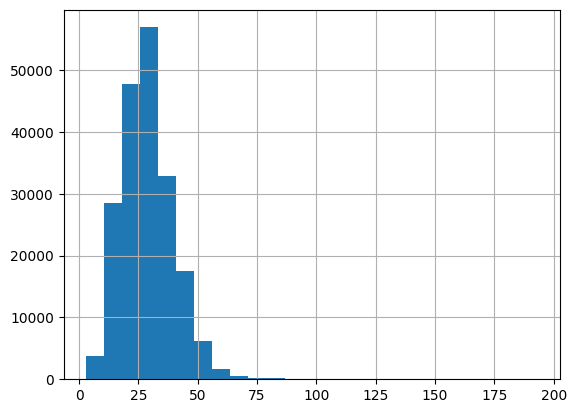

In [5]:
print(df['sequence'].apply(len).describe(percentiles=[.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9, .95, .98, .99, .995, .998, .999]))
df['sequence'].apply(len).hist(bins=25);

In [6]:
pd.set_option('display.max_colwidth', 100)
df.loc[df['sequence'].apply(lambda text: len(text) > 64)]

,sequence,target
83,how to determine if a piecewise multivariable function is continuous,information_intent
125,which amendment to the constitution is known as the prohibition amendment? quizlet,information_intent
182,the _______ is the layer of the atmosphere in which weather occurs. a. exosphere b. mesosphere c...,weather_intent
682,does your ira contribution have to be deposited or mailed by deadline,information_intent
1249,"Compare prices for relocation services in Los Angeles, California",yelp_intent
...,...,...
195475,which pr option involves members of government to affect recovery,information_intent
195519,​a legal maximum on the price at which a good can be sold is called a price,information_intent
195543,which of the following organelles are common to both prokaryotic and eukaryotic cells?,information_intent
195907,what was the most important revolution of the industrial revolution,information_intent


In [7]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

token_lengths = []
for sequence in df['sequence'].values:
    tokens = tokenizer(sequence, truncation=False)['input_ids']  # Get tokenized input IDs
    token_lengths.append(len(tokens))

# Create a DataFrame for analysis
temp_df = pd.DataFrame({'sequence': df['sequence'].values, 'token_length': token_lengths})

# Display token lengths
print(temp_df)

# Optional: Analyze token lengths for deciding the best max_length
print(f"Max token length: {temp_df['token_length'].max()}")
print(f"Average token length: {temp_df['token_length'].mean()}")
print(f"90th percentile token length: {temp_df['token_length'].quantile(0.9)}")
print(f"95th percentile token length: {temp_df['token_length'].quantile(0.95)}")
print(f"98th percentile token length: {temp_df['token_length'].quantile(0.98)}")
print(f"99th percentile token length: {temp_df['token_length'].quantile(0.99)}")
print(f"99.5th percentile token length: {temp_df['token_length'].quantile(0.995)}")
print(f"99.9th percentile token length: {temp_df['token_length'].quantile(0.999)}")

del temp_df

/home/jupyter/new_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                    sequence  token_length
0                               Breaking Bad             4
1                  what is japanese knotweed             7
2               what framing square used for             7
3       diseases that are caused by bacteria             8
4             how to register on expedia.com            11
...                                      ...           ...
196247     chase custom finance phone number             7
196248                     burrow definition             5
196249         calories in riced cauliflower            10
196250           Best bars in Cape Girardeau             9
196251                   define incapacitate             6

[196252 rows x 2 columns]
Max token length: 55
Average token length: 8.146332266677536
90th percentile token length: 11.0
95th percentile token length: 13.0
98th percentile token length: 14.0
99th percentile token length: 15.0
99.5th percentile token length: 16.0
99.9th percentile token len

In [8]:
# Select only a sample from the actual data

sampling_percentages = {
    'information_intent': 1.0,   # 100% sampling for information_intent
    'yelp_intent': 1.0,          # 100% sampling for yelp_intent
    'weather_intent': 1.0,       # 100% sampling for weather_intent
    'navigation_intent': 1.0,    # 100% sampling for navigation_intent
    'purchase_intent': 1.0,      # 100% sampling for purchase_intent
    'translation_intent': 1.0,   # 100% sampling for translation_intent
    'travel_intent': 1.0,        # 100% sampling for travel_intent
    'unknown': 1.0               # 100% sampling for unknown
}

# Sample from each target group based on the defined percentages
sampled_df = df.groupby('target', group_keys=False).apply(
    lambda x: x.sample(frac=sampling_percentages.get(x.name, 1.0))
).reset_index(drop=True)

sampled_df['label'] = sampled_df['target'].map(label2id)
# sampled_df = sampled_df.rename(columns={'target': 'label'})

print(sampled_df['label'].value_counts())
print(f"Size of sampled_df = {len(sampled_df)}")
sampled_df.head()

label
0    120902
1     28290
2     14332
5     13750
4      7893
3      6686
6      2294
7      2105
Name: count, dtype: int64
Size of sampled_df = 196252


/var/tmp/ipykernel_54611/1383443563.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('target', group_keys=False).apply(


,sequence,target,label
0,what are the iliopsoas muscles,information_intent,0
1,what is kratom herb,information_intent,0
2,natural remedies for constipation due to medications,information_intent,0
3,why did queen elizabeth 1 have mary 1 executed,information_intent,0
4,what is a hostel,information_intent,0


In [9]:
# Step 1: Split the DataFrame into train and validation sets
train_df, val_df = train_test_split(sampled_df, test_size=0.05, random_state=42, stratify=sampled_df['label'])

# Step 2: Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

# Step 3: Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Step 4: Verify the structure of DatasetDict
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['sequence', 'target', 'label'],
        num_rows: 186439
    })
    validation: Dataset({
        features: ['sequence', 'target', 'label'],
        num_rows: 9813
    })
})


In [10]:
train_df['label'].value_counts()

label
0    114857
1     26875
2     13615
5     13063
4      7498
3      6352
6      2179
7      2000
Name: count, dtype: int64

In [11]:
val_df['label'].value_counts()

label
0    6045
1    1415
2     717
5     687
4     395
3     334
6     115
7     105
Name: count, dtype: int64

#### Preprocess data

In [12]:


# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["sequence"]

    # tokenize and truncate text
    tokenizer.truncation_side = "right"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,  # Pad the sequences to the longest in the batch
        max_length=64
    )
    return tokenized_inputs

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)
# tokenized_dataset = tokenized_dataset.map(fix_labels)
tokenized_dataset

Map: 100%|██████████| 9813/9813 [00:00<00:00, 25407.47 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sequence', 'target', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 186439
    })
    validation: Dataset({
        features: ['sequence', 'target', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9813
    })
})

#### Evaluation Metrics

In [14]:
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=1)
    # Combine metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [15]:
### Evaluate untrained model

text_list = [
    'floor repair cost',
    'denture fix',
    'who is the us president',
    'italian food',
    'sandwiches in seattle',
    'seattle weather',
    'weather seattle',
    'boston wether',
    'Boston wether',
    'weather boston',
    'weather Boston',
    'Weather Boston',
    'weathr boston',
    'seattle weathr',
    'apple macbook price',
    'sf sushi',
    'sf ramen',
    'seattle sushi',
    'seattle ramen',
    'sushi sf',
    'ramen sf',
    'chase bank login',
    'passport application',
    'walm',
    'footbal',
    'movers quote','its sushi', 'average house cleaning rates', 'fun things to do', 'foster gwin', 'go karts', 'facial', 'donuts',
    'via carota', 'tomi jazz', 'mun korean steakhouse', 'la pecora bianca', 'birria tacos', 'bank of america', 'bungee fitness',
    'allien', 'proposa', 'wather', 'big city', 'orlando bloom', 'banana', 'lenght',
]

print("Untrained model predictions:")
print("----------------------------")
predictions = []
logits_list = []
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt")
    logits = model(inputs).logits
    prediction = torch.argmax(logits, dim=1).item()
    predictions.append(prediction)
    print(text + " -> " + id2label[prediction])

Untrained model predictions:
----------------------------
floor repair cost -> yelp_intent
denture fix -> yelp_intent
who is the us president -> yelp_intent
italian food -> yelp_intent
sandwiches in seattle -> yelp_intent
seattle weather -> yelp_intent
weather seattle -> yelp_intent
boston wether -> yelp_intent
Boston wether -> yelp_intent
weather boston -> yelp_intent
weather Boston -> yelp_intent
Weather Boston -> yelp_intent
weathr boston -> yelp_intent
seattle weathr -> yelp_intent
apple macbook price -> yelp_intent
sf sushi -> yelp_intent
sf ramen -> yelp_intent
seattle sushi -> yelp_intent
seattle ramen -> yelp_intent
sushi sf -> yelp_intent
ramen sf -> yelp_intent
chase bank login -> yelp_intent
passport application -> yelp_intent
walm -> yelp_intent
footbal -> yelp_intent
movers quote -> yelp_intent
its sushi -> yelp_intent
average house cleaning rates -> yelp_intent
fun things to do -> yelp_intent
foster gwin -> yelp_intent
go karts -> yelp_intent
facial -> yelp_intent
donuts 

#### Model finetuning with LoRA

In [16]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                         r=16, # intrinsic rank of trainable weight matrix
                         lora_alpha=32, # similar to learning_rate
                         lora_dropout=0.01, # probability of dropout nodes
                         target_modules=['attention.self.query', 'attention.self.key']) # LoRA is applied to query layer


model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 200,712 || all params: 24,786,704 || trainable%: 0.8098


In [17]:
# for name, module in model.named_modules():
#     print(name)

#### Define hyper parameters and training arguments

In [18]:
from transformers import EarlyStoppingCallback

lr = 1e-4
batch_size = 32
num_epochs = 12

# training args
training_args = TrainingArguments(
    # output_dir=model_checkpoint + "-lora-intent-classification-v3",
    output_dir="mobilebert-uncased" + "-lora-intent-classification-v6",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # warmup_steps=1000,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
trainer = Trainer(
    model=model, 
    args=training_args, # Hyperparamaters
    train_dataset=tokenized_dataset["train"], # training data
    eval_dataset=tokenized_dataset["validation"], # validation data
    tokenizer=tokenizer, # tokenizer
    data_collator=data_collator, # dynamic sequence padding
    compute_metrics=compute_metrics,  # model perfomance evaluation metric
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,13.634600,3.573355,0.885560,0.887858,0.885560,0.882967
2,40.045600,2.440991,0.923061,0.930207,0.923061,0.925753
3,30.031800,0.907024,0.942933,0.941680,0.942933,0.941776
4,12.083200,0.602224,0.948436,0.947712,0.948436,0.947804
5,7.150300,0.179747,0.952716,0.952055,0.952716,0.952296
6,16.257400,0.194166,0.954041,0.953524,0.954041,0.953687
7,9.919100,0.507980,0.955671,0.955129,0.955671,0.955230
8,11.940600,2.557006,0.957302,0.957090,0.957302,0.957142


TrainOutput(global_step=46616, training_loss=5480.535536407463, metrics={'train_runtime': 5398.9449, 'train_samples_per_second': 414.39, 'train_steps_per_second': 12.951, 'total_flos': 8005097728964160.0, 'train_loss': 5480.535536407463, 'epoch': 8.0})

In [21]:
# trainer.model

In [22]:
trainer.model.eval()
with torch.no_grad():
    for text in text_list:
        inputs = tokenizer.encode(text, return_tensors="pt").to(device)
        logits = trainer.model(inputs).logits
        prediction = torch.argmax(logits, dim=1).item()
        print(text + " -> " + id2label[prediction])

floor repair cost -> yelp_intent
denture fix -> yelp_intent
who is the us president -> information_intent
italian food -> yelp_intent
sandwiches in seattle -> yelp_intent
seattle weather -> weather_intent
weather seattle -> weather_intent
boston wether -> weather_intent
Boston wether -> weather_intent
weather boston -> weather_intent
weather Boston -> weather_intent
Weather Boston -> weather_intent
weathr boston -> weather_intent
seattle weathr -> weather_intent
apple macbook price -> purchase_intent
sf sushi -> yelp_intent
sf ramen -> yelp_intent
seattle sushi -> yelp_intent
seattle ramen -> yelp_intent
sushi sf -> yelp_intent
ramen sf -> yelp_intent
chase bank login -> navigation_intent
passport application -> navigation_intent
walm -> unknown
footbal -> yelp_intent
movers quote -> yelp_intent
its sushi -> yelp_intent
average house cleaning rates -> yelp_intent
fun things to do -> yelp_intent
foster gwin -> yelp_intent
go karts -> yelp_intent
facial -> information_intent
donuts -> ye

In [23]:
!ls -lh mobilebert-uncased-lora-intent-classification-v6/checkpoint-46616

total 3.4M
-rw-r--r-- 1 jupyter jupyter 5.0K Nov 20 05:24 README.md
-rw-r--r-- 1 jupyter jupyter  706 Nov 20 05:24 adapter_config.json
-rw-r--r-- 1 jupyter jupyter 798K Nov 20 05:24 adapter_model.safetensors
-rw-r--r-- 1 jupyter jupyter 1.7M Nov 20 05:24 optimizer.pt
-rw-r--r-- 1 jupyter jupyter  14K Nov 20 05:24 rng_state.pth
-rw-r--r-- 1 jupyter jupyter 1.1K Nov 20 05:24 scheduler.pt
-rw-r--r-- 1 jupyter jupyter  125 Nov 20 05:24 special_tokens_map.json
-rw-r--r-- 1 jupyter jupyter 695K Nov 20 05:24 tokenizer.json
-rw-r--r-- 1 jupyter jupyter 1.3K Nov 20 05:24 tokenizer_config.json
-rw-r--r-- 1 jupyter jupyter  20K Nov 20 05:24 trainer_state.json
-rw-r--r-- 1 jupyter jupyter 5.2K Nov 20 05:24 training_args.bin
-rw-r--r-- 1 jupyter jupyter 227K Nov 20 05:24 vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Load the LoRA model from checkpoint after training

In [24]:
id2label = {0: 'information_intent',
            1: 'yelp_intent',
            2: 'navigation_intent',
            3: 'travel_intent',
            4: 'purchase_intent',
            5: 'weather_intent',
            6: 'translation_intent',
            7: 'unknown'}
label2id = {label:id for id,label in id2label.items()}


output_dir = "mobilebert-uncased-lora-intent-classification-v6/checkpoint-46616"

# Load the tokenizer (from the output directory)
tokenizer = AutoTokenizer.from_pretrained(output_dir, return_tensors="pt", padding="max_length", truncation=True, max_length=64)

# Load the base model from the original checkpoint (base pre-trained model)
base_model = AutoModelForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=8, id2label=id2label, label2id=label2id)

# Load the LoRA configuration and model
peft_config = PeftConfig.from_pretrained(output_dir)
lora_model = PeftModel.from_pretrained(base_model, output_dir)

# Step 3: Save the combined model to a directory
save_directory = "tmp/mobilebert_lora_combined_model/"
lora_model.save_pretrained(save_directory)  # Save base model + LoRA weights

# Now the `lora_model` contains both the base model and the LoRA weights.
lora_model.eval()

# Example inference
inputs = tokenizer(["looking for home cleaning "], return_tensors="pt")
outputs = lora_model(**inputs)
logits = outputs.logits
print(logits)


prediction = torch.argmax(logits, dim=1).item()
print(prediction, id2label[prediction])
probabilities = torch.softmax(logits, dim=1)
rounded_probabilities = torch.round(probabilities)
print(rounded_probabilities)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[ -3.2607,   7.3945,  -4.3247,  -8.0733,   1.8455,  -4.7625, -10.6814,
          -5.6815]], grad_fn=<AddmmBackward0>)
1 yelp_intent
tensor([[0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<RoundBackward0>)


In [25]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Step 1: Load the base model (DistilBERT)
base_model = AutoModelForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=8, id2label=id2label, label2id=label2id)

# Step 2: Load the LoRA adapter weights
output_dir = "mobilebert-uncased-lora-intent-classification-v6/checkpoint-46616"
peft_config = PeftConfig.from_pretrained(output_dir)
lora_model = PeftModel.from_pretrained(base_model, output_dir)

# Step 3: Merge LoRA weights into the base model
# After this, the model will have both base and LoRA weights applied
merged_model = lora_model.merge_and_unload()

# Step 4: Save the full model (base model + LoRA weights)
save_directory = "tmp/mobilebert_lora_combined_model/"
merged_model.save_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(output_dir)  # Load the tokenizer
tokenizer.save_pretrained(save_directory)  # Save the tokenizer


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('tmp/mobilebert_lora_combined_model/tokenizer_config.json',
 'tmp/mobilebert_lora_combined_model/special_tokens_map.json',
 'tmp/mobilebert_lora_combined_model/vocab.txt',
 'tmp/mobilebert_lora_combined_model/added_tokens.json',
 'tmp/mobilebert_lora_combined_model/tokenizer.json')

In [26]:
# !huggingface-cli whoami

In [28]:
merged_model_dir = "tmp/mobilebert_lora_combined_model"
merged_repo_id = "Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier"  

merged_model.push_to_hub(merged_repo_id)
tokenizer.push_to_hub(merged_repo_id)

model.safetensors: 100%|██████████| 98.5M/98.5M [00:03<00:00, 26.2MB/s]
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier/commit/268e37cb720741e2eee30bbc01005798432cf545', commit_message='Upload tokenizer', commit_description='', oid='268e37cb720741e2eee30bbc01005798432cf545', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier'), pr_revision=None, pr_num=None)